## Peak Detection - Data Wrangling

In this notebook, a sensor data csv is taken, that captures the motion of Truc over 1 day.  

It has a huge amount of noisy data of IMU sensors - Timestamp, xAccel, yAccel, zAccel

The Sensor Data Csv is filtered, indexed againt timestamp and peaks are identified in data as braking events. 

Using Data Wrangling in Pandas, we are able to filter out the prominent braking events

A Matplotlib Visuaitsation of Raw Data and Identified Braking Events is done.  

### Import Packages

In [1]:
import os 
import sys

In [2]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import plotly.graph_objects as go
from glob import glob
from datetime import timedelta


In [205]:
def pre_processing( df):
    """
    Preprocess the raw csv file 
        - converts timestamp into datetime dtype
        - sorts the data as per the timestamp
        - set timestamp column as index for time based indexing 
        -smoothens the accelermeter data - xAccel, yAccel, zAccel using a rolling mean filter \
        and scales to to m/s2 unit
    """
    df['timestamp'] = pd.to_datetime( df['timestamp'] )
    df.sort_values( by = 'timestamp', inplace = True)
    df.set_index( keys = 'timestamp', drop = False, inplace = True)
    df['accx'] = df['xAccel'].dropna().rolling(10).mean()*1e-2
    df['accy'] = df['yAccel'].dropna().rolling(10).mean()*1e-2
    df['accz'] = df['zAccel'].dropna().rolling(10).mean()*1e-2   

    return df

In [43]:
def get_peaks( time_series):
    """
    Finds the negative peaks in the accelerometer data
    Start, Highest Point and End of the peak is Detected. 
    Negative Peaks are a zone of braking when the vehicle speeds gets reduced due to deceleration
    
    """
    negative_peaks =  find_peaks( -time_series, width = 4 )[0]
    negative_peaks = [ i for i in negative_peaks if time_series.iloc[i] < -2]
    peak_starts_list = []
    peak_ends_list = []
    peak_values = []
    for peak in negative_peaks:
        try:
            offset_end = np.where( time_series.iloc[peak:] > 0 )[0][0]
        except Exception as e:
            offset_end = np.argmin(time_series.iloc[peak:])
            
            
        try:
            peak_start = np.where( time_series.iloc[:peak] > 0 )[0][-1]
        except Exception as e:
            peak_start = np.argmax(time_series.iloc[:peak])

        peak_starts_list.append(peak_start)
        
        peak_end = peak+offset_end
        peak_ends_list.append(peak_end)
        peak_values.append(time_series.iloc[peak])
        
    return negative_peaks, peak_ends_list, peak_values, peak_starts_list

In [34]:
def speed_buckets(speed):
    if speed < 30: 
        return "<30"
    elif speed < 40:
        return "30-40"
    elif speed < 50:
        return '40-50'
    elif speed < 60:
        return "50-60"
    else :
        return "60+"
        

In [35]:
def get_braking_stats( df, t1, t2): 
    speed_start = df[t1 - timedelta(seconds = 2) : t1 + timedelta(seconds = 2)]['gnss_speedData_speed'].round(2).max()
    speed_end = df[t2 - timedelta(seconds = 2) : t2 + timedelta(seconds = 2)]['gnss_speedData_speed'].round(2).min()
    
    df = df.loc[t1 : t2].copy()
    df = df.loc[df[['accx']].dropna().index].copy()
    df.reset_index(inplace = True, drop = True)
    df['timedelta'] = df['timestamp'] - df['timestamp'].shift()
    df['timedelta_ms'] = df['timedelta'].dt.total_seconds()*1000
    
    df['accx_delta'] = df['accx'] - df['accx'].shift()
    df['accy_delta'] = df['accy'] - df['accy'].shift()
    df['accz_delta'] = df['accz'] - df['accz'].shift()
    
    df['xjerk'] = df['accx_delta']/df['timedelta_ms']
    df['yjerk'] = df['accy_delta']/df['timedelta_ms']
    df['zjerk'] = df['accz_delta']/df['timedelta_ms']
    
    xjerk = df['xjerk'].abs().round(2).max() if df[df['xjerk'].abs() >=2].shape[0] >=2 else np.nan
    yjerk = df['yjerk'].abs().round(2).max() if df[df['yjerk'].abs() >=2].shape[0] >=2 else np.nan
    zjerk = df['zjerk'].abs().round(2).max() if df[df['zjerk'].abs() >=2].shape[0] >=2 else np.nan

    return speed_start, speed_end,xjerk,yjerk,zjerk

In [234]:
def get_brakes(df): 
    """
    Pink Peaks in Data and Categorises 
    """
    inds = df['accx'].dropna().index
    df['negative_peaks'] = False
    cols = ['peak_height', 'peak_start', 'peak_end', 'peak_duration', 'speed_start', 'speed_end', 'jerk']
    for col in cols : 
        df[col] = np.nan
    negative_peaks, peak_ends, peak_values, peak_str = get_peaks( df['accx'].dropna())
    if negative_peaks:
        df.loc[inds[negative_peaks], 'negative_peaks'] = True
        df.loc[inds[negative_peaks], 'peak_height'] = peak_values
        df.loc[inds[negative_peaks], 'peak_start'] = inds[peak_str]
        df.loc[inds[negative_peaks], 'peak_end'] = inds[peak_ends]
        df['peak_duration'] = (df['peak_end'] - df['peak_start']).dt.total_seconds()
        speed_start, speed_end,xjerk,yjerk,zjerk = zip(*df.loc[inds[negative_peaks]].apply( lambda row: get_braking_stats( df, row['peak_start'], row['peak_end']), axis = 1).values)
        df.loc[inds[negative_peaks], 'speed_start'] = speed_start
        df.loc[inds[negative_peaks], 'speed_end'] = speed_end
        df.loc[inds[negative_peaks], 'jerk'] = xjerk
        return df.loc[inds[negative_peaks]]

    return pd.DataFrame()
    

## Loading Sample Data and Identyfying Brakes

In [245]:
df = pd.read_csv( 'sample_sensor_data.csv')

In [246]:
result_df = pd.DataFrame()

df = pre_processing( df)
brake_df = get_brakes(df)
result_df = result_df.append(brake_df)



## Visualising the Raw Sensor Data

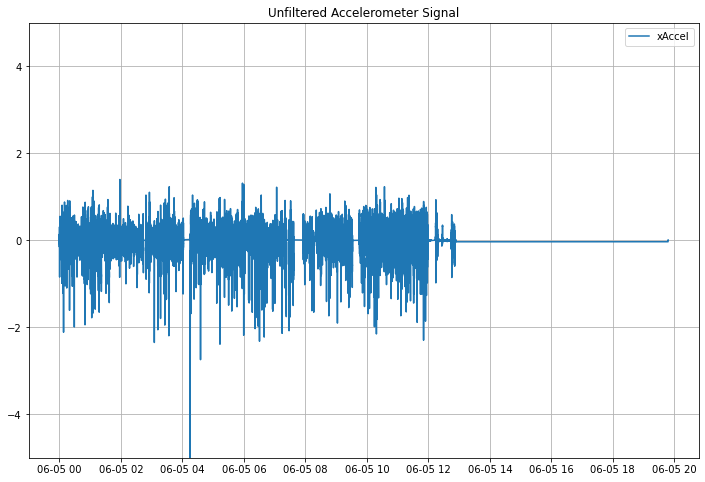

In [247]:
fig , ax = plt.subplots(1,1, figsize = (12,8))
ax.plot(df['accx'].dropna() , label = 'xAccel')


ax.set_ylim( -5,5)
ax.set_title( f"Unfiltered Accelerometer Signal", fontsize = 12)
ax.grid()
ax.legend()

As is clear from the above. the the raw sensor data is quite noisy and huge, so this data needs to be analysed for peaks

### Filtering Out the Data for Brake Event Identification and Visualisation"

In [262]:
cols = ['timestamp','negative_peaks', 'peak_height','peak_start', 'peak_end','peak_duration', 'speed_start', 'speed_end',]

In [263]:
result_df = result_df[cols]
result_df_main = result_df.copy()
result_df = result_df.query("peak_duration < 10").sort_values(['peak_height']).query('speed_start - speed_end  >= 20')
result_df = result_df.reset_index(drop = True).rename(columns = {'index' : 'peak_time'})


In [264]:
result_df

,timestamp,negative_peaks,peak_height,peak_start,peak_end,peak_duration,speed_start,speed_end
0,2022-06-05 03:05:18.706,True,-2.348,2022-06-05 03:05:14.726000,2022-06-05 03:05:21.690000,6.964,49.0,10.0
1,2022-06-05 10:18:41.809,True,-2.152,2022-06-05 10:18:36.833000,2022-06-05 10:18:43.814000,6.981,50.0,20.0
2,2022-06-05 07:28:15.249,True,-2.078,2022-06-05 07:28:12.234000,2022-06-05 07:28:21.254000,9.020,44.0,22.0


In [265]:
plt.rcParams['savefig.facecolor'] = "0.8"

### PLotting The Identified Breaks

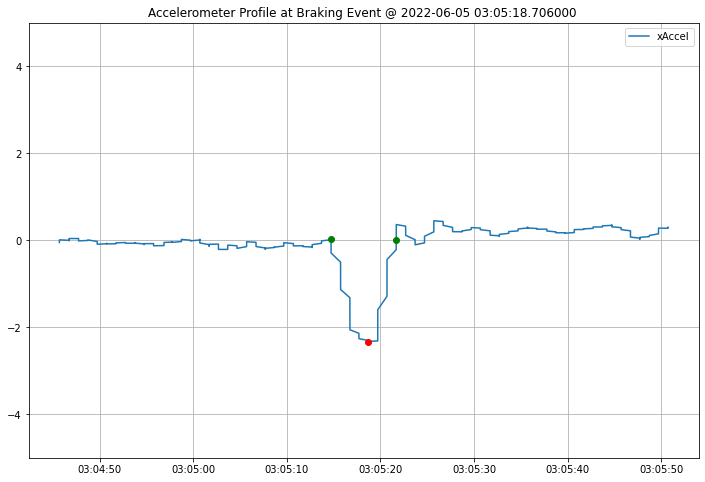

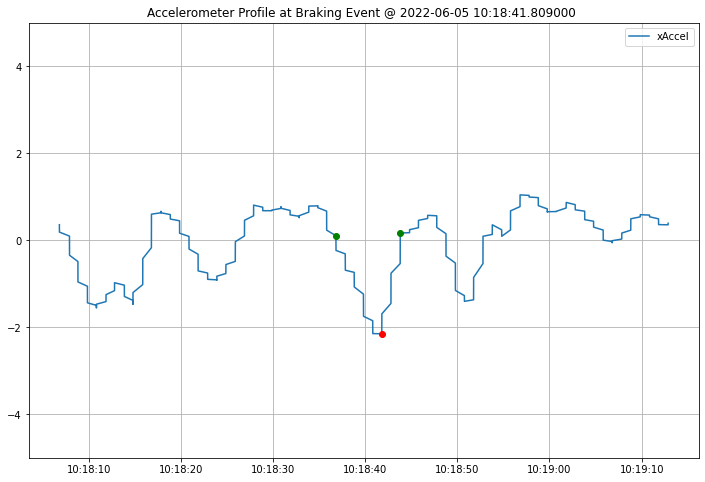

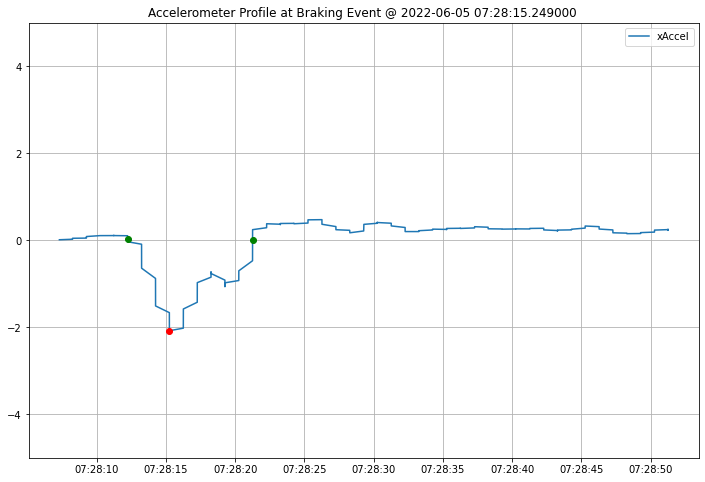

In [266]:
for i, (st,en,ind )in enumerate(zip( result_df['peak_start'], result_df['peak_end'],result_df.timestamp )):
    fig , ax = plt.subplots(1,1, figsize = (12,8))
    ax.plot(df[st - timedelta(seconds =30):en + timedelta(seconds =30)]['accx'].dropna() , label = 'xAccel')
    ax.plot(ind, df.loc[ind,'accx'], 'ro' , )
    ax.plot(st, df.loc[st,'accx'], 'go' )
    ax.plot(en, df.loc[en,'accx'], 'go' )

    ax.set_ylim( -5,5)
    ax.set_title( f"Accelerometer Profile at Braking Event @ {ind} ", fontsize = 12)
    ax.grid()
    ax.legend()
    fig.savefig(f"event_{i}.png", )

    
    
 